In [8]:
from pathlib import Path

import numpy as np
import pandas as pd
from numba import njit, prange

from matplotlib import pyplot as plt

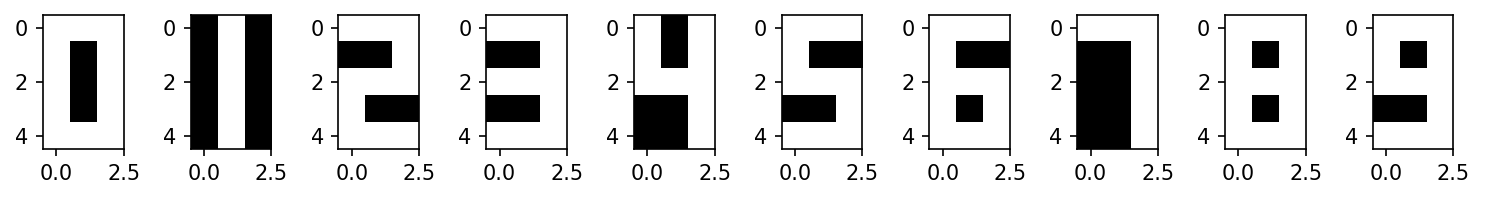

In [9]:
fig, axes = plt.subplots(nrows=1, ncols=10)

fig.set_figwidth(10)
fig.set_dpi(150)

nums_mtrx =  np.loadtxt(Path('.', 'basic', 'numbers.txt'))

for n, ax in zip(nums_mtrx, axes.ravel()):
    ax.imshow(n.reshape(5, 3), cmap='gray')

plt.tight_layout()
plt.show()

In [10]:
cells_columns = [f'c{n}' for n in range(15)]
classes = ['zero','one','two','three','four','five','six','seven','eight','nine']

df = pd.DataFrame(columns=cells_columns+['class'])

for i in range(10):
    new_row = dict(zip(cells_columns, nums_mtrx[i]))
    new_row['class'] = classes[i]
    
    df.loc[df.index.size] = new_row

    for j in range(9):
        noised_num = nums_mtrx[i] + np.random.uniform(0, 0.5, 15)
        
        new_row = dict(zip(cells_columns, noised_num))
        new_row['class'] = classes[i]
        
        df.loc[df.index.size] = new_row

for name in df['class'].unique():
    df[f'{name}_label'] = df['class'].map(lambda x: 1 if x == name else 0)

In [11]:
test_frac = 0.7

p = np.arange(10)

test_size = int(p.size*test_frac)
train_size = int(p.size*(1-test_frac))

idx_test = np.ravel([(p[0 : test_size] + i*10) for i in range(10)])
idx_train = np.ravel([(p[test_size : p.size] + i*10) for i in range(10)])

features_columns = cells_columns
label_columns = [f"{name}_label" for name in classes]

xTest = np.array(df.iloc[idx_test][features_columns])
yTest = np.array(df.iloc[idx_test][label_columns])

xTrain = np.array(df.iloc[idx_train][features_columns])
yTrain = np.array(df.iloc[idx_train][label_columns])

In [12]:
@njit(fastmath=True)
def F(x: np.ndarray) -> np.ndarray:
    # return x
    return np.maximum(np.zeros(x.shape), x)
    # return np.clip(x,-1, 1)
    # return np.tanh(x)


@njit(fastmath=True)
def dF(x: np.ndarray) -> np.ndarray:
    # return np.ones(x.shape)
    return 1 * (x > 0)
    # return np.array([0 if xi <= -1 or xi >= 1 else 1 for xi in x])
    # return 1-np.square(np.tanh(x))


@njit(fastmath=True)
def sigmoid(x: np.ndarray) -> np.ndarray:
    return 1/(1+np.exp(-x))


@njit(fastmath=True)
def dSigmoid(x: np.ndarray) -> np.ndarray:
    y = 1/(1+np.exp(-x))
    return y*(1-y)


@njit(fastmath=True)
def softmax(x: np.ndarray) -> np.ndarray:
    y = np.exp(x)
    return y/np.sum(y)

In [17]:
@njit(fastmath=True)
def grads(xBatch: np.ndarray, yBatch: np.ndarray, Wh: np.ndarray, Wy: np.ndarray, Bh: np.ndarray, b: np.ndarray) -> tuple[np.ndarray]:
    dWh = np.zeros(Wh.shape)
    dWy = np.zeros(Wy.shape)

    dBh = np.zeros(Bh.shape)
    db = np.zeros(b.shape)

    u = np.zeros((Wh.shape[0], Wh.shape[2]))
    h = np.zeros(Wh.shape[2])
    
    for i in prange(xBatch.shape[0]):
        h *= 0

        for j in range(Wh.shape[0]):
            u[j] = xBatch[i] @ Wh[j] + Bh[j]
            h += F(u[j])

        y = softmax(h @ Wy + b)
        
        for j in range(Wh.shape[0]):
            dWh[j] += np.outer(xBatch[i], (y - yBatch[i]) @ Wy.T * dF(u[j]))
            dBh[j] += (y - yBatch[i]) @ Wy.T * dF(u[j])
            
        dWy += np.outer(h, y - yBatch[i])
        db += (y - yBatch[i])
    
    return (dWh, dWy, dBh, db)


class MultiPerceptron:
    def __init__(self, nIn: int, nH:int, nL:int, nOut: int) -> None:
        self.nIn = nIn
        self.nH = nH
        self.nL = nL
        self.nOut = nOut
        
        self.Wh: np.ndarray = np.random.uniform(-1, 1, (nL, nIn, nH))
        self.Wy: np.ndarray = np.random.uniform(-1, 1, (nH, nOut))
        
        self.Bh: np.ndarray = np.zeros((nL, nH))
        self.b: np.ndarray = np.zeros(nOut)

    def predict(self, x:np.ndarray) -> np.ndarray:
        h = np.zeros(self.nH)

        for i in range(self.nL):
            h += F(x @ self.Wh[i] + self.Bh[i])
                
        return softmax(h @ self.Wy + self.b)

    def train(self, xTrain: np.ndarray, yTrain: np.ndarray, lr, batch_size, max_epoch) -> None:
        n = xTrain.shape[0]

        for epoch in range(max_epoch):
            idxs = np.random.choice(a=np.arange(n), size=batch_size, replace=False)

            for batch_idx in range(n//batch_size):
                ibegin, iend = batch_idx*batch_size, min((batch_idx+1)*batch_size, n-1)
                batch_idxs = idxs[ibegin:iend]
            
                dWh, dWy, dBh, db = grads(xTrain[batch_idxs], yTrain[batch_idxs], self.Wh, self.Wy, self.Bh, self.b)

                self.Wh -= lr*dWh
                self.Wy -= lr*dWy

                self.Bh -= lr*dBh
                self.b -= lr*db
        
    def loss(self, x: np.ndarray, y: np.ndarray) -> float:
        Ypred = np.array([self.predict(xi) for xi in x])
        h = -np.mean(y*np.log(Ypred), axis=1)
        return np.mean(h)

In [25]:
nIn = 15
nH = 5
nL = 5
nOut = 10

lr = 1e-2
batch_size = 30
max_epoch = 10000

model = MultiPerceptron(nIn, nH, nL, nOut)

print('untrained loss: {0:.6f}'.format(model.loss(xTest, yTest)))

model.train(xTrain, yTrain, lr, batch_size, max_epoch)

print('trained loss: {0:.6f}'.format(model.loss(xTest, yTest)))

TP_count = 0
for x, y in zip(xTest, yTest):
    yPred = model.predict(x)
    TP_count += 1 if np.argmax(y) == np.argmax(yPred) else 0

accuracy = TP_count / xTest.shape[0]
print(f"test set accuracy: {round(accuracy*100, 2)}%")

untrained loss: 0.594974
trained loss: 0.005733
test set accuracy: 97.14%


In [26]:
TP_count = 0
n_samples = 20000
for i in range(n_samples):
    j = i%10
    x = nums_mtrx[j] + np.random.uniform(0, 0.5, 15)
    yPred = model.predict(x)
    TP_count += 1 if j == np.argmax(yPred) else 0

print(f"accuracy: {round(TP_count/n_samples*100, 2)}% ({TP_count} of {n_samples})")

accuracy: 94.46% (18892 of 20000)


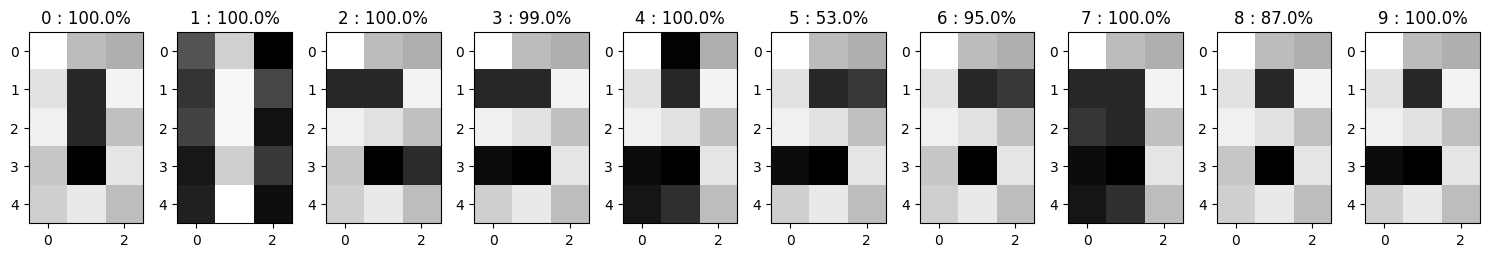

In [27]:
x_noised = nums_mtrx + np.random.uniform(0, 0.5, 15)

yPred = list([model.predict(xi) for xi in x_noised])

fig, axes = plt.subplots(nrows=1, ncols=10)

fig.set_dpi(100)
fig.set_figwidth(15)
fig.set_figheight(5)

for i, ax in enumerate(axes.ravel()):
    ax.imshow(x_noised[i].reshape((5,3)),  cmap='gray')
    j = np.argmax(yPred[i])
    ax.set_title(f"{j} : {(yPred[i][j]*100).round()}%")

plt.autoscale()
plt.tight_layout()
plt.show()